# Analysis of Slides 991 and 992
**Goal:**  Merge and describe slides 991 and 992    
**Input:**  Adata objects from 991 and 992     
**Output:** Descriptive statistics comparing both slides     
**Author:** Jose Nimo    
**Date_of_creation:** 15.01.2025     
**Date_of_latest_modification:** 15.04.2025    
**Status:** Completed, amendments pending

# Setup and Imports

In [3]:
import os,sys,time
from loguru import logger 

# import scimap as sm #only import what you need

import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
from opendvp import anndata_utils
from opendvp import filtering
from opendvp import imaging
import importlib

for package in [np,pd,gpd,ad]:
    print(f"{package.__name__} {package.__version__}")

numpy 1.26.4
pandas 2.2.2
geopandas 1.0.1
anndata 0.11.3


## Step 1: Merge phenotyped adatas

In [2]:
adata_991 = ad.read_h5ad("../data/perSample/991/adata_checkpoints/7_adata_pheno/20250302_1823_7_adata_pheno_adata.h5ad")
adata_992 = ad.read_h5ad("../data/perSample/992/adata_checkpoints/7_adata_pheno/20250303_1112_7_adata_pheno_adata.h5ad")

In [3]:
adata_concat = ad.concat([adata_991,adata_992])

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [15]:
adata_concat.obs['imageid'].value_counts()

imageid
992    1005051
991     610182
Name: count, dtype: int64

In [27]:
adata_concat.obs['cell_id'] = adata_concat.obs['imageid'].astype('str') + "_" + adata_concat.obs['CellID'].astype('str')

In [ ]:
anndata_utils.save_adata_checkpoint(adata_concat, path_to_dir="../data/perSample/991_992/", checkpoint_name="0_concat")

2025-03-03 13:36:30.990 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 13:36:33.154 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 13:36:33.154 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 13:36:33.953 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


# 11.04.2025: Compare phenotypes

In [27]:
from opendvp.utils import export_figure

## How many of each cell type per slide

### Load dataset

In [2]:
adata = ad.read_h5ad("../data/perSample/991_992/1_spatial_LDA/20250303_1654_1_spatial_LDA_adata.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'
    layers: 'log'

### Barplot of celltypes, absolute and frequency

In [151]:
x_axis='imageid'
y_axis='phenotype'

data = pd.DataFrame(adata.obs)[[x_axis, y_axis]].astype(str)
data.head()

,imageid,phenotype
0,991,Cancer_cells
1,991,Cancer_cells
2,991,Cancer_cells
3,991,CD4_Tcells
4,991,Cancer_cells


In [152]:
total = data.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)
total

imageid
991     610182
992    1005051
dtype: int64

In [153]:
rg = pd.DataFrame(
    data.groupby([x_axis, y_axis])
    .size()
    .unstack()
    .fillna(0)
    .div(total, axis=0)
    .stack()
)
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values='count')

In [154]:
# load colors
import json
with open("../assets/pheno_colors.json") as f:
    pheno_colors = json.load(f)
pheno_colors

{'B_cells': '#ff7df3',
 'CD4_Tcells': '#6efa6e',
 'CD8_Tcells': '#2020d8',
 'Cancer_cells': '#f55148',
 'Vimentin_cells': '#866a21',
 'Macrophages': '#ffff00',
 'COL1A1_cells': '#ff7f0e',
 'Unknown': '#7f7f7f'}

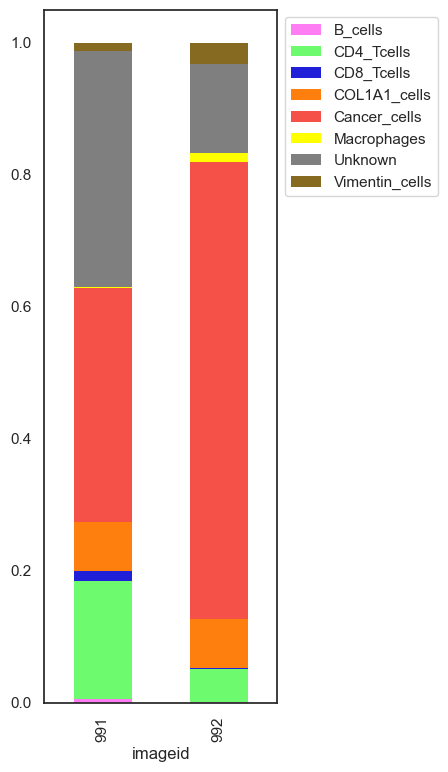

In [155]:
fig,ax = plt.subplots()
fig.set_size_inches(3, 9)
pivot_df.plot.bar(color=pheno_colors, stacked=True, ax=ax, edgecolor='none')
plt.legend(bbox_to_anchor=(1,1))
export_figure(fig, "../figures/phenotype_bar_plot/", suffix="pheno_bar_relative")
plt.show()

### absolute numbers

In [37]:
rg = pd.DataFrame(
    data.groupby([x_axis, y_axis])
    .size()
    .unstack()
    .fillna(0)
    # .div(total, axis=0)
    .stack()
)
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values='count')

  imageid     phenotype   count
0     991       B_cells    3578
1     991    CD4_Tcells  109335
2     991    CD8_Tcells    8826
3     991  COL1A1_cells   45124
4     991  Cancer_cells  216397 


phenotype  B_cells  CD4_Tcells  CD8_Tcells  COL1A1_cells  Cancer_cells  \
imageid                                                                  
991           3578      109335        8826         45124        216397   
992            388       50369        2034         75164        694938   

phenotype  Macrophages  Unknown  Vimentin_cells  
imageid                                          
991                921   218068            7933  
992              14218   134974           32966  


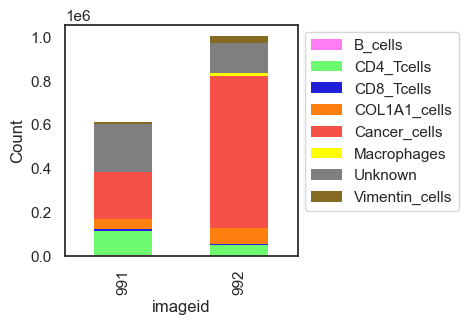

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(3, 3)
pivot_df.plot.bar(
    color=pheno_colors,
    stacked=True,
    ax=ax,
    edgecolor='none'  # Remove white lines
)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Count")  # optional, but good to label
plt.show()

### fix y axis

In [40]:
# Calculate max total count across all stacked bars
y_max = pivot_df.sum(axis=1).max()
y_max

1005051

In [41]:
tick_step = 250_000
yticks = np.arange(0, y_max + tick_step, tick_step)
yticks

array([      0,  250000,  500000,  750000, 1000000, 1250000])

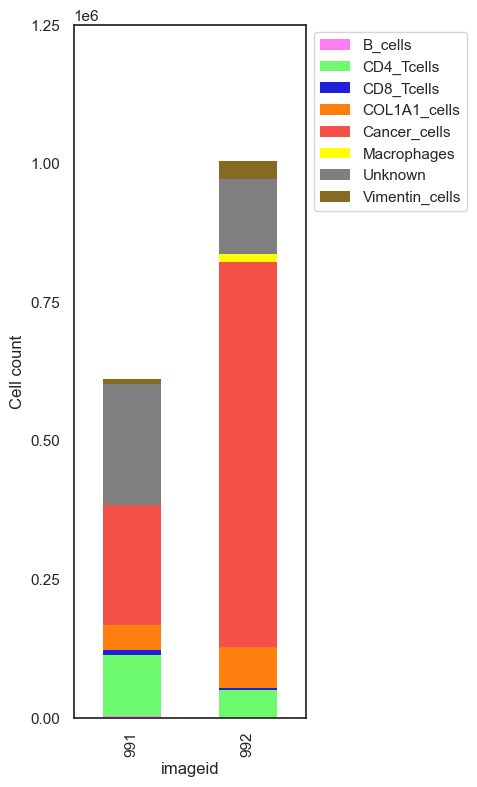

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate max total count across all stacked bars
y_max = pivot_df.sum(axis=1).max()

# Define custom tick marks (e.g., every 100k up to max)
tick_step = 250_000
yticks = np.arange(0, y_max + tick_step, tick_step)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(3, 9)

pivot_df.plot.bar(
    stacked=True,
    color=pheno_colors,
    ax=ax,
    edgecolor='none'
)

# Set y-axis manually
ax.set_ylim(0, y_max)
ax.set_yticks(yticks)
ax.set_ylabel("Cell count")

plt.legend(bbox_to_anchor=(1, 1))
# plt.tight_layout()
export_figure(fig, "../figures/phenotype_bar_plot/", suffix="pheno_bar")
plt.show()

## Heatmap for measured intensities 

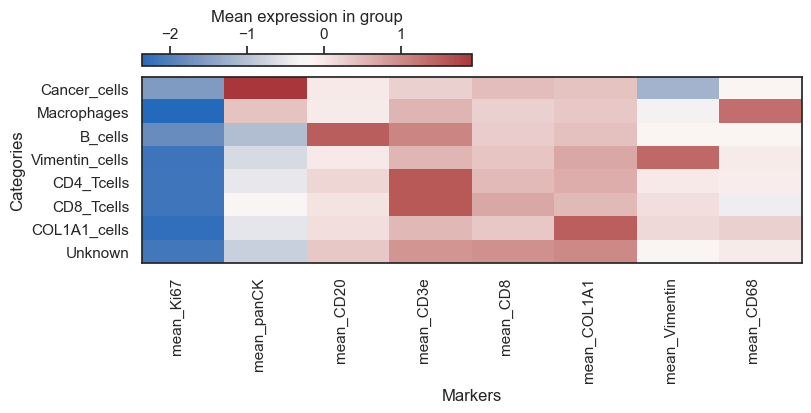

In [43]:
sm.pl.heatmap(adata, groupBy="phenotype", figsize=(8,4), standardScale="column")

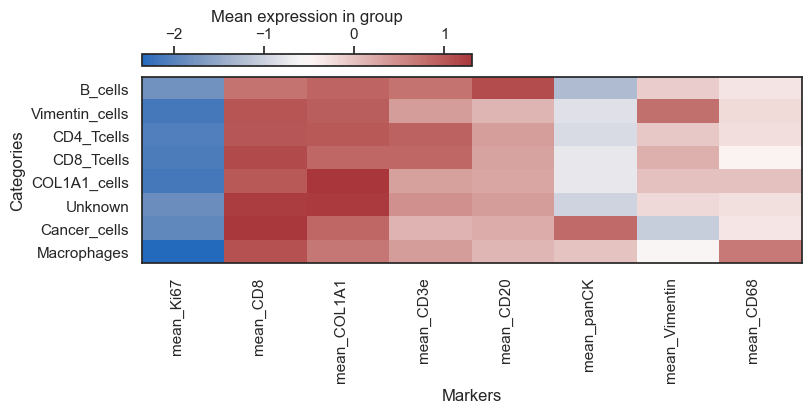

In [45]:
sm.pl.heatmap(adata, layer="log", groupBy="phenotype", figsize=(8,4), standardScale="column")

In [54]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'
    layers: 'log'

In [57]:
adata.var_names

Index(['mean_Vimentin', 'mean_CD3e', 'mean_panCK', 'mean_CD8', 'mean_COL1A1',
       'mean_CD20', 'mean_CD68', 'mean_Ki67'],
      dtype='object')

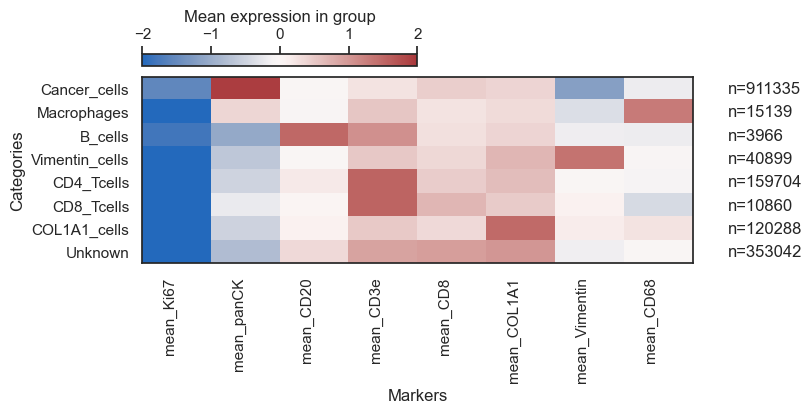

In [62]:
sm.pl.heatmap(
    adata=adata,
    groupBy="phenotype",
    # layer="log",
    # subsetGroups=["B_cells","Vimentin_cells", "CD4_Tcells", "CD8_Tcells", "COL1A1_cells", "Cancer_cells", "Macrophages"],
    # subsetMarkers = ['mean_Vimentin', 'mean_CD3e', 'mean_panCK', 'mean_CD8', 'mean_COL1A1','mean_CD20', 'mean_CD68',],
    clusterRows=True,
    clusterColumns=True,
    standardScale="column",
    showPrevalence=True,
    figsize=(8,4),
    vmin=-2, vmax=2,
    # saveDir = '../figures/heatmap/',
    # fileName = '20250411_markers_celltypes.pdf'
    )

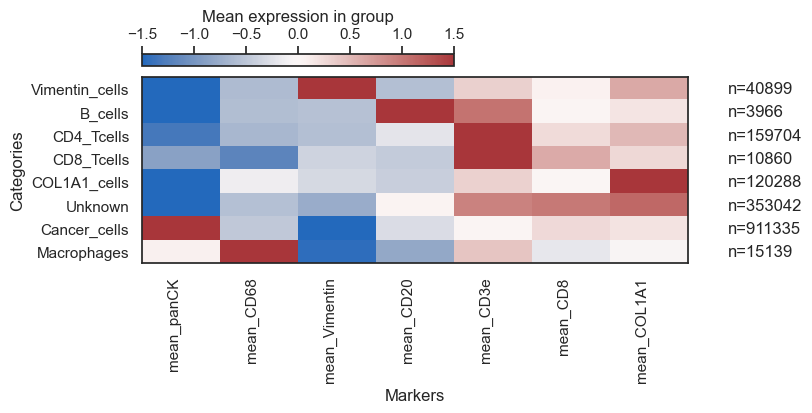

In [58]:
sm.pl.heatmap(
    adata=adata,
    groupBy="phenotype",
    # layer="log",
    # subsetGroups=["B_cells","Vimentin_cells", "CD4_Tcells", "CD8_Tcells", "COL1A1_cells", "Cancer_cells", "Macrophages"],
    subsetMarkers = ['mean_Vimentin', 'mean_CD3e', 'mean_panCK', 'mean_CD8', 'mean_COL1A1','mean_CD20', 'mean_CD68'],
    clusterRows=True,
    clusterColumns=True,
    standardScale="column",
    showPrevalence=True,
    figsize=(8,4),
    vmin=-1.5, vmax=1.5,
    # saveDir = '../figures/heatmap/',
    # fileName = '20250411_markers_celltypes.pdf'
    )

In [63]:
sm.pl.heatmap(
    adata=adata,
    groupBy="phenotype",
    # layer="log",
    # subsetGroups=["B_cells","Vimentin_cells", "CD4_Tcells", "CD8_Tcells", "COL1A1_cells", "Cancer_cells", "Macrophages"],
    subsetMarkers = ['mean_Vimentin', 'mean_CD3e', 'mean_panCK', 'mean_CD8', 'mean_COL1A1','mean_CD20', 'mean_CD68'],
    clusterRows=True,
    clusterColumns=True,
    standardScale="column",
    showPrevalence=True,
    figsize=(8,4),
    vmin=-1.5, vmax=1.5,
    saveDir = '../figures/heatmap/',
    fileName = '20250411_markers_celltypes.pdf'
    )

Saved heatmap to ../figures/heatmap/20250411_markers_celltypes.pdf


### density plot

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



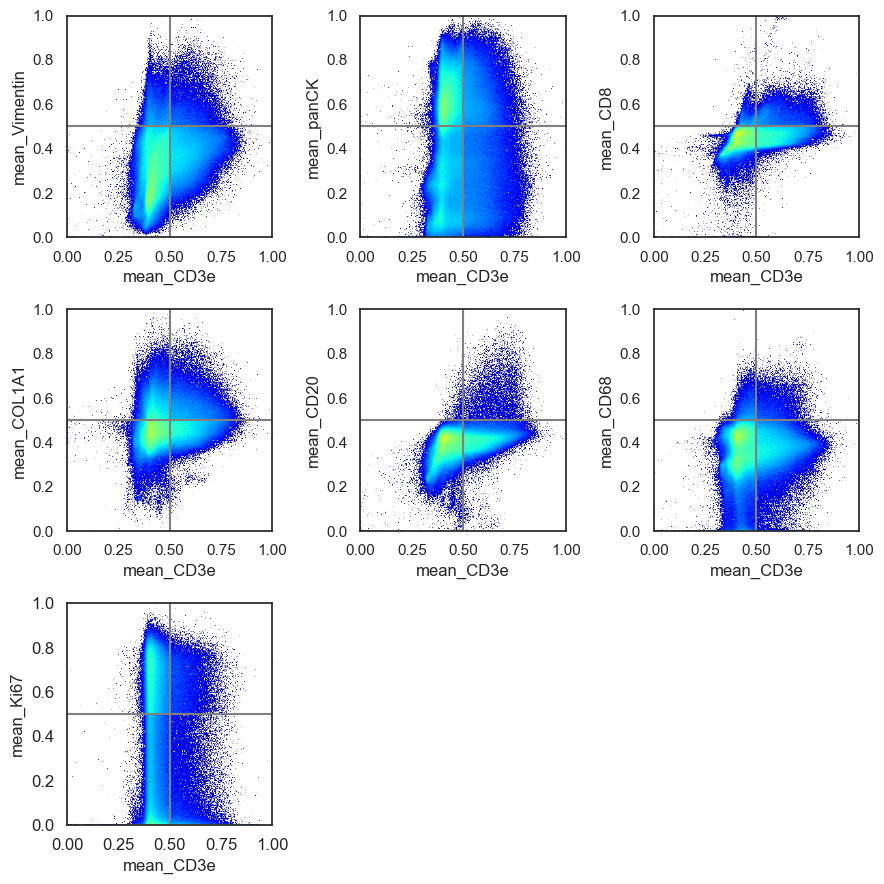

In [71]:
sm.pl.densityPlot2D(
    adata, 
    markerA="mean_CD3e", 
    # markerB="mean_CD8", 
    layer=None, 
    subset=None, 
    imageid='imageid', ncols=None, 
    cmap='jet', figsize=(3, 3), 
    fontsize=None, dpi=150, xticks=None, yticks=None,
    # saveDir="../figures/2Ddensity/",
    # fileName="mean_CD3e.pdf"
    )

In [70]:
#save for every marker

for marker in adata.var_names:
    sm.pl.densityPlot2D(
        adata, 
        markerA=marker, 
        # markerB="mean_CD8", 
        layer=None, 
        subset=None, 
        imageid='imageid', ncols=None, 
        cmap='jet', figsize=(3, 3), 
        fontsize=None, dpi=150, xticks=None, yticks=None,
        saveDir="../figures/2Ddensity/",
        fileName=f"{marker}_2Ddensity_plots.pdf")

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_Vimentin_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_CD3e_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_panCK_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_CD8_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_COL1A1_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_CD20_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_CD68_2Ddensity_plots.pdf


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



Saved heatmap to ../figures/2Ddensity/mean_Ki67_2Ddensity_plots.pdf


### correlation plots

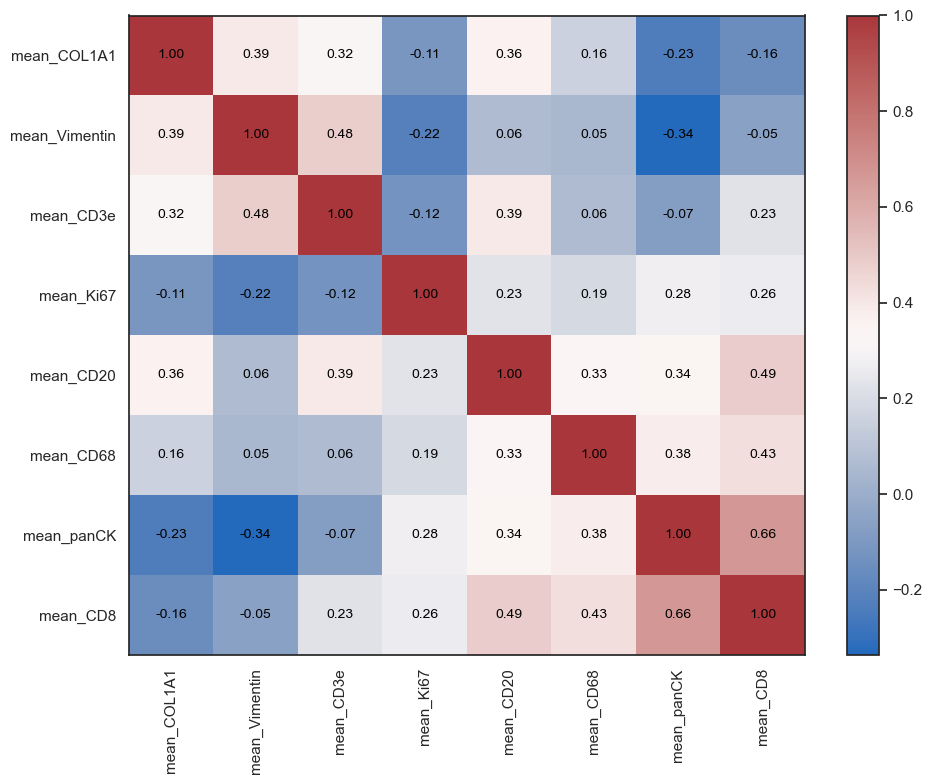

In [76]:
sm.pl.markerCorrelation(adata, layer='log', 
                subsetMarkers=None, 
                orderRow=None, orderColumn=None, 
                clusterRows=True, clusterColumns=True, 
                cmap='vlag', figsize=None, overlayValues=True, 
                fontSize=10, fontColor='black', 
                # fileName='markerCorrelation.pdf', saveDir="../figures/correlation/"
                )

In [75]:
sm.pl.markerCorrelation(adata, layer='log', 
                subsetMarkers=None, 
                orderRow=None, orderColumn=None, 
                clusterRows=True, clusterColumns=True, 
                cmap='vlag', figsize=None, overlayValues=True, 
                fontSize=10, fontColor='black', 
                fileName='markerCorrelation.pdf', saveDir="../figures/correlation/")

Saved plot to ../figures/correlation/markerCorrelation.pdf


### Spatial Distance

In [79]:
adata = sm.tl.spatial_distance(adata, phenotype='phenotype')

Processing Image: 991
Processing Image: 992


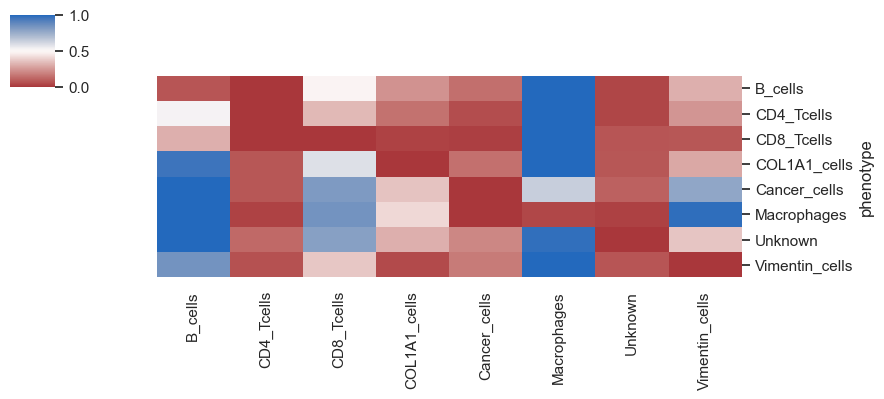

In [81]:
sm.pl.spatial_distance(adata, heatmap_summarize=True, figsize=(9,4))

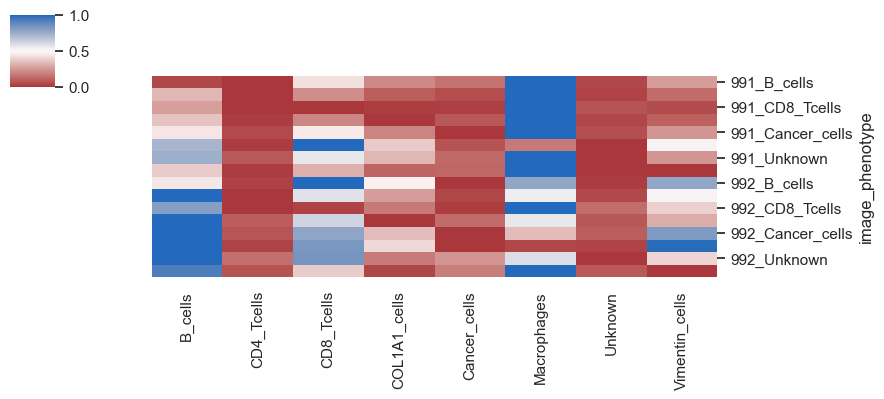

In [80]:
sm.pl.spatial_distance(adata, heatmap_summarize=False, figsize=(9,4))

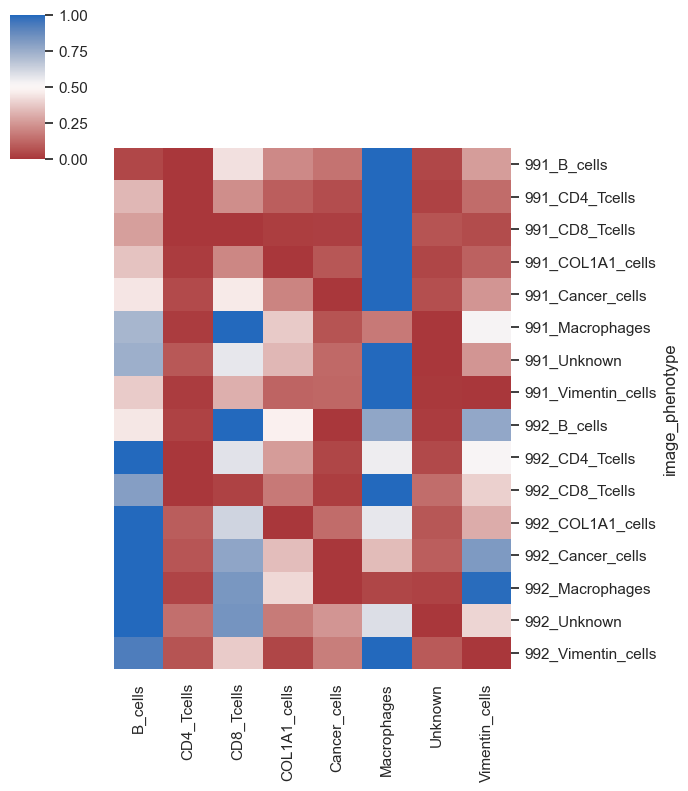

In [85]:
sm.pl.spatial_distance (adata, heatmap_summarize=False, imageid='imageid', figsize=(7,8))

In [ ]:
spatial_distance(adata, spatial_distance='spatial_distance', phenotype='phenotype', imageid='imageid', log=False, 
                 method='heatmap', 
                 heatmap_summarize=True, 
                 heatmap_na_color='grey', 
                 heatmap_cmap='vlag_r', 
                 heatmap_row_cluster=False, 
                 heatmap_col_cluster=False, 
                 heatmap_standard_scale=0, 
                 distance_from=None, distance_to=None, x_axis=None, y_axis=None, 
                 facet_by=None, plot_type=None, 
                 return_data=False, subset_col=None, subset_value=None, fileName='spatial_distance.pdf', saveDir=None, **kwargs)

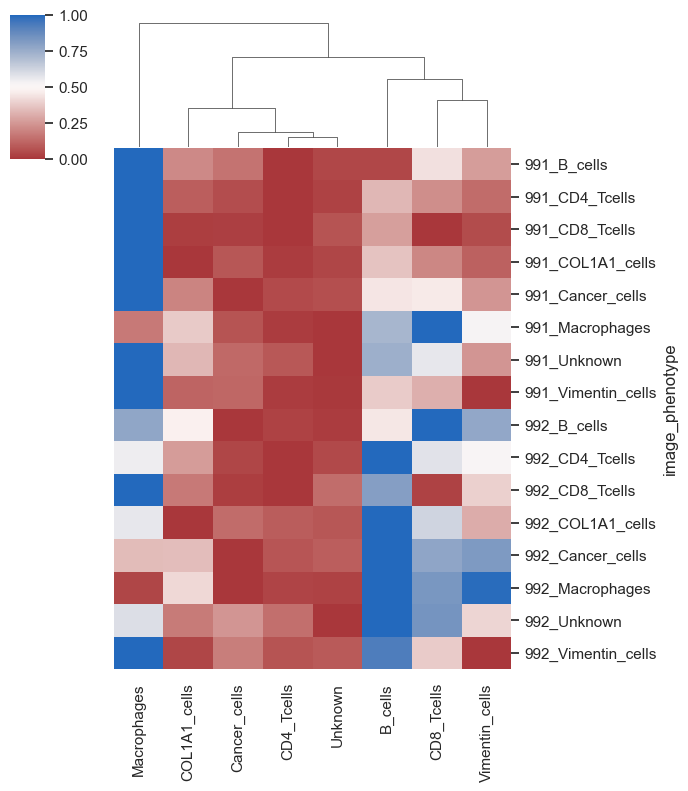

In [94]:
sm.pl.spatial_distance (adata, 
                        heatmap_row_cluster=False, 
                        heatmap_col_cluster=True,                         
                        heatmap_summarize=False, 
                        imageid='imageid', 
                        figsize=(7,8))

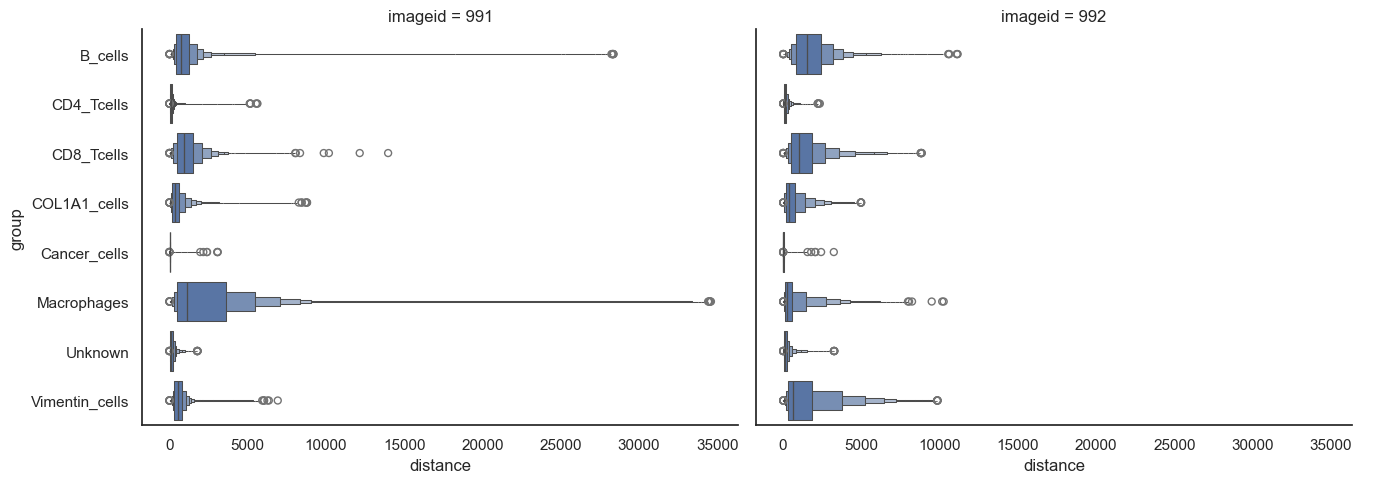

In [88]:
sm.pl.spatial_distance (adata, method='numeric', distance_from='Cancer_cells', imageid="imageid", height=5, aspect=11/8, log=False)

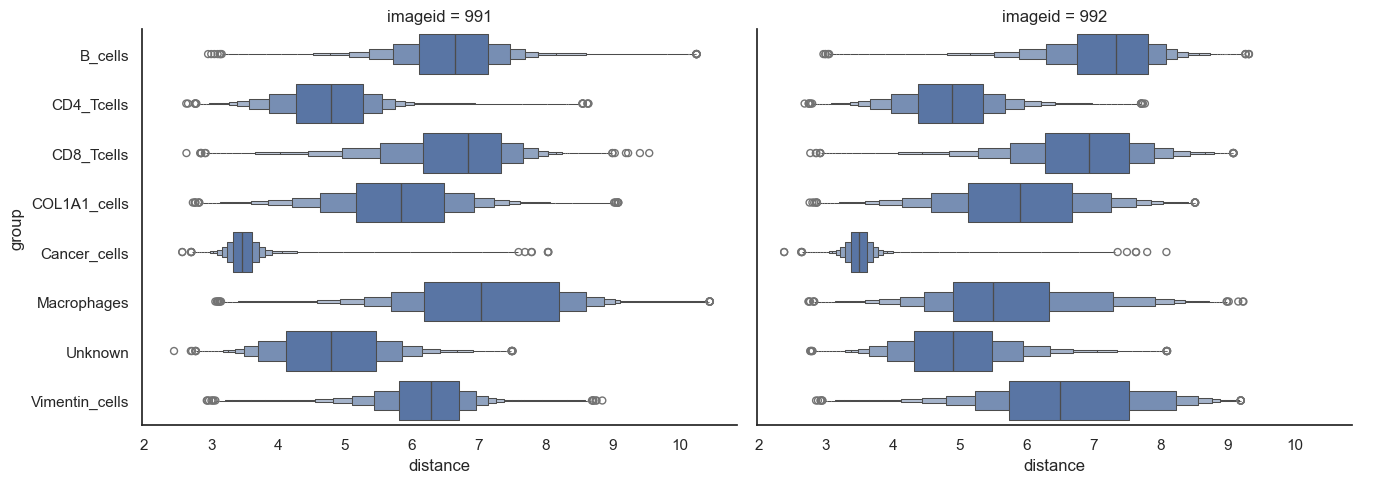

In [87]:
sm.pl.spatial_distance (adata, method='numeric', distance_from='Cancer_cells', imageid="imageid", height=5, aspect=11/8, log=True)

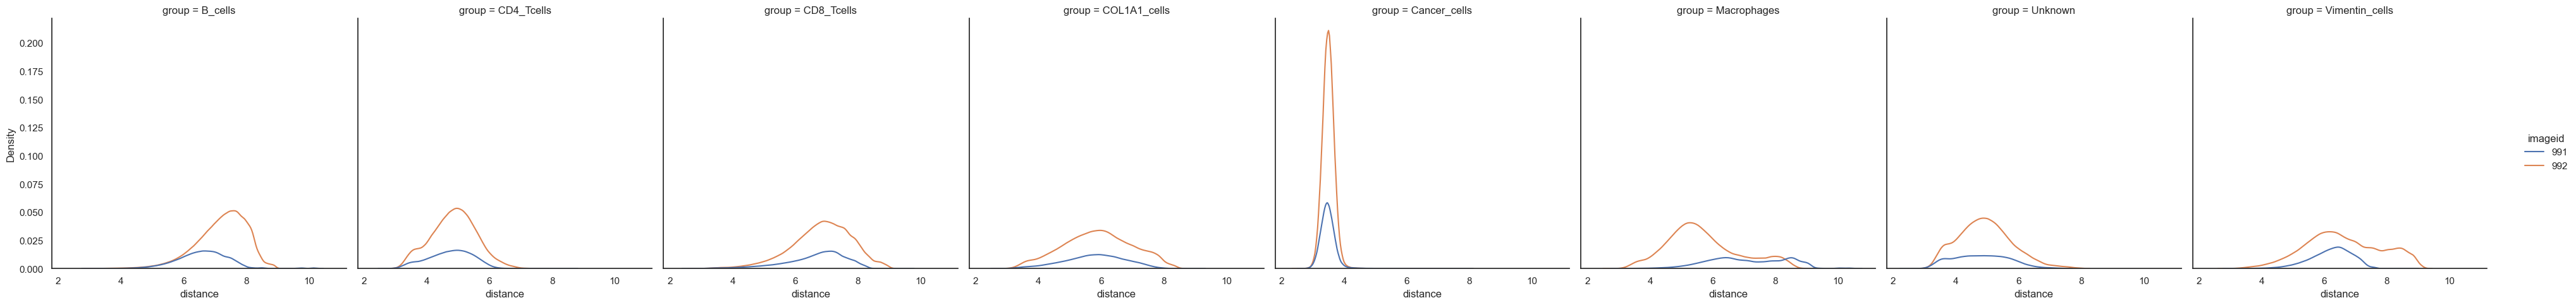

In [90]:
sm.pl.spatial_distance (adata, method='distribution', distance_from='Cancer_cells', imageid="imageid", log=True)

### Spatial Interaction

In [104]:
adata = sm.tl.spatial_interaction (adata, 
                                  method='radius', 
                                  radius=70, 
                                  label='spatial_interaction_radius')

Processing Image: [991]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: [992]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Consolidating the permutation results


In [112]:
adata = sm.tl.spatial_interaction(adata, 
                                  method='radius', 
                                  imageid = 'imageid',
                                  radius=70, 
                                  label='spatial_interaction_radius_perimage')

Processing Image: [991]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: [992]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


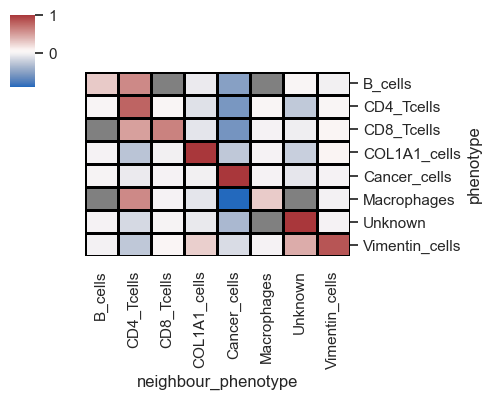

In [115]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_radius_perimage',
                          linewidths=0.75, linecolor='black', figsize=(5,4))

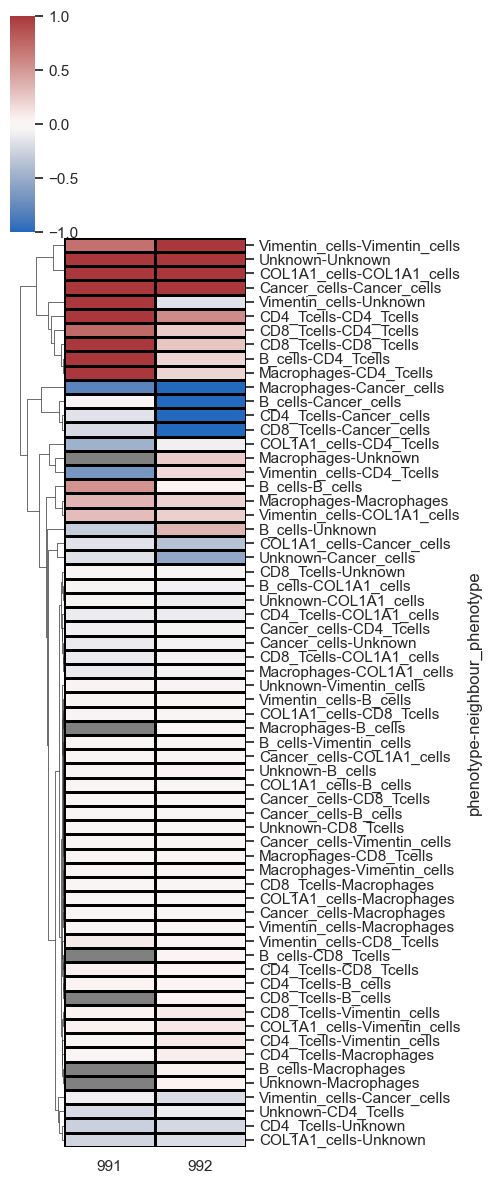

In [117]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_radius_perimage',
                          yticklabels=True, figsize=(5,12), row_cluster=True,
                          summarize_plot=False,
                          linewidths=0.75, linecolor='black')

In [134]:
for key, value in adata.uns.items():
    if isinstance(value, pd.DataFrame):
        print(f"Found DataFrame under key: '{key}'")
        
        # Check each column name
        new_columns = []
        for col in value.columns:
            if not isinstance(col, str):
                print(f"  Non-string column header: {col} (type: {type(col)})")
                new_columns.append(str(col))
            else:
                new_columns.append(col)
        
        # Replace columns with string versions if needed
        if new_columns != list(value.columns):
            value.columns = new_columns

Found DataFrame under key: 'spatial_lda_knn14'
Found DataFrame under key: 'spatial_lda_knn14_probability'
Found DataFrame under key: 'spatial_lda_knn21'
Found DataFrame under key: 'spatial_lda_knn21_probability'
Found DataFrame under key: 'spatial_lda_knn30'
Found DataFrame under key: 'spatial_lda_knn30_probability'
Found DataFrame under key: 'spatial_lda_knn40'
Found DataFrame under key: 'spatial_lda_knn40_probability'
Found DataFrame under key: 'spatial_lda_knn50'
Found DataFrame under key: 'spatial_lda_knn50_probability'
Found DataFrame under key: 'spatial_lda_knn7'
Found DataFrame under key: 'spatial_lda_knn7_probability'
Found DataFrame under key: 'spatial_distance'
Found DataFrame under key: 'spatial_interaction_radius'
  Non-string column header: 991 (type: <class 'numpy.int64'>)
  Non-string column header: 992 (type: <class 'numpy.int64'>)
Found DataFrame under key: 'spatial_interaction_radius_perimage'
  Non-string column header: 991 (type: <class 'numpy.int64'>)
  Non-string 

In [135]:
#save adata
anndata_utils.save_adata_checkpoint(adata=adata, path_to_dir="../data/perSample/991_992/", checkpoint_name="2_spatial_distance")

2025-04-11 15:44:22.597 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:83 - Writing h5ad
2025-04-11 15:44:28.194 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:85 - Wrote h5ad file
2025-04-11 15:44:28.196 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:92 - Writing parquet
2025-04-11 15:44:30.353 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:94 - Wrote parquet file


## Corrections: 
 - barplot without unknown
 - consider using manually set threshold for FACS like density plots

In [136]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_distance', 'spatial_interaction_radius', 'spatial_interaction_radius_perimage', 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn

In [137]:
x_axis='imageid'
y_axis='phenotype'

data = pd.DataFrame(adata.obs)[[x_axis, y_axis]].astype(str)
data.head()

,imageid,phenotype
0,991,Cancer_cells
1,991,Cancer_cells
2,991,Cancer_cells
3,991,CD4_Tcells
4,991,Cancer_cells


In [142]:
#remove unknown
data = data[data['phenotype']!= "Unknown"]
data.phenotype.value_counts()

phenotype
Cancer_cells      911335
CD4_Tcells        159704
COL1A1_cells      120288
Vimentin_cells     40899
Macrophages        15139
CD8_Tcells         10860
B_cells             3966
Name: count, dtype: int64

In [143]:
total = data.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)
total

imageid
991    392114
992    870077
dtype: int64

In [144]:
rg = pd.DataFrame(
    data.groupby([x_axis, y_axis])
    .size()
    .unstack()
    .fillna(0)
    .div(total, axis=0)
    .stack()
)
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values='count')

In [145]:
# load colors
import json
with open("../assets/pheno_colors.json") as f:
    pheno_colors = json.load(f)
pheno_colors

{'B_cells': '#ff7df3',
 'CD4_Tcells': '#6efa6e',
 'CD8_Tcells': '#2020d8',
 'Cancer_cells': '#f55148',
 'Vimentin_cells': '#866a21',
 'Macrophages': '#ffff00',
 'COL1A1_cells': '#ff7f0e',
 'Unknown': '#7f7f7f'}

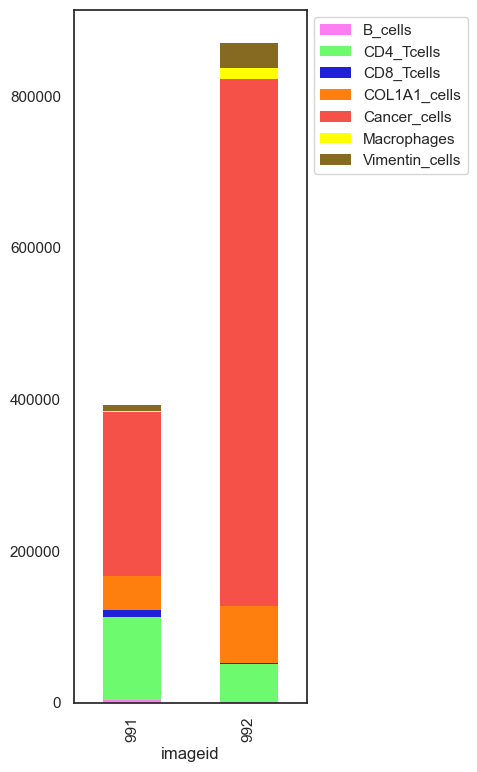

In [149]:
fig,ax = plt.subplots()
fig.set_size_inches(3, 9)
pivot_df.plot.bar(color=pheno_colors, stacked=True, ax=ax, edgecolor='none')
plt.legend(bbox_to_anchor=(1,1))
export_figure(fig, "../figures/phenotype_bar_plot/", suffix="pheno_bar_relative_no_unknown")
plt.show()

In [147]:
rg = pd.DataFrame(
    data.groupby([x_axis, y_axis])
    .size()
    .unstack()
    .fillna(0)
    # .div(total, axis=0)
    .stack()
)
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values='count')

y_max = pivot_df.sum(axis=1).max()
tick_step = 250_000
yticks = np.arange(0, y_max + tick_step, tick_step)
yticks

array([      0,  250000,  500000,  750000, 1000000])

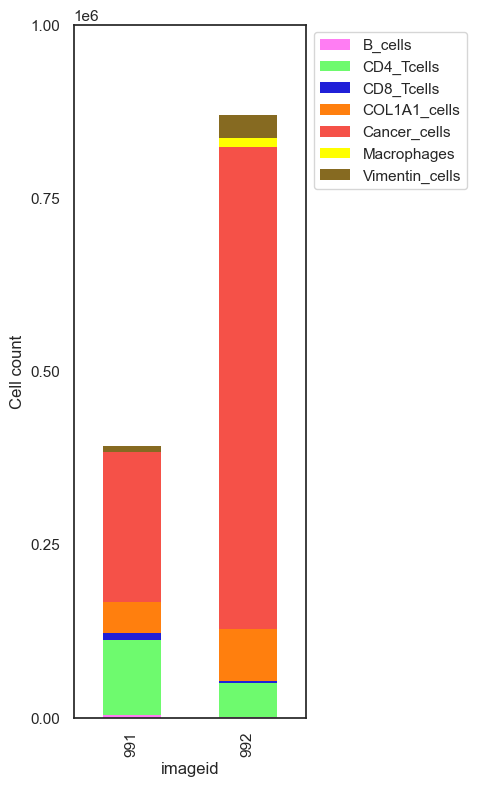

In [150]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(3, 9)

pivot_df.plot.bar(
    stacked=True,
    color=pheno_colors,
    ax=ax,
    edgecolor='none'
)

# Set y-axis manually
ax.set_ylim(0, y_max)
ax.set_yticks(yticks)
ax.set_ylabel("Cell count")

plt.legend(bbox_to_anchor=(1, 1))
# plt.tight_layout()
export_figure(fig, "../figures/phenotype_bar_plot/", suffix="pheno_bar_absolute_no_unknown")
plt.show()

# 15.04.2025 export relative barplot